# Melanoma Detection Case Study

## Problem statement:
To buld CNN model to detect Melanoma by studying the images

### Importing all the important libraries

In [29]:
import pathlib
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [30]:
from glob import glob

In [59]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [32]:
# Defining the path for train and test images

data_dir_train = '/content/drive/MyDrive/Upgrad/SkinCancer/Train'
data_dir_test = '/content/drive/MyDrive/Upgrad/SkinCancer/Test'

In [33]:
# Count the number of image in Train and Test directory

train_image_files = glob("/content/drive/MyDrive/Upgrad/SkinCancer/Train/*/*.jpg")
train_image_count = len(train_image_files)

print("Train image files: {}".format(train_image_count))

test_image_files = glob("/content/drive/MyDrive/Upgrad/SkinCancer/Test/*/*.jpg")
test_image_count = len(test_image_files)

print("Test image files: {}".format(test_image_count))

Train image files: 2239
Test image files: 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [34]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [35]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

#Train Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [36]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

#Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [37]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

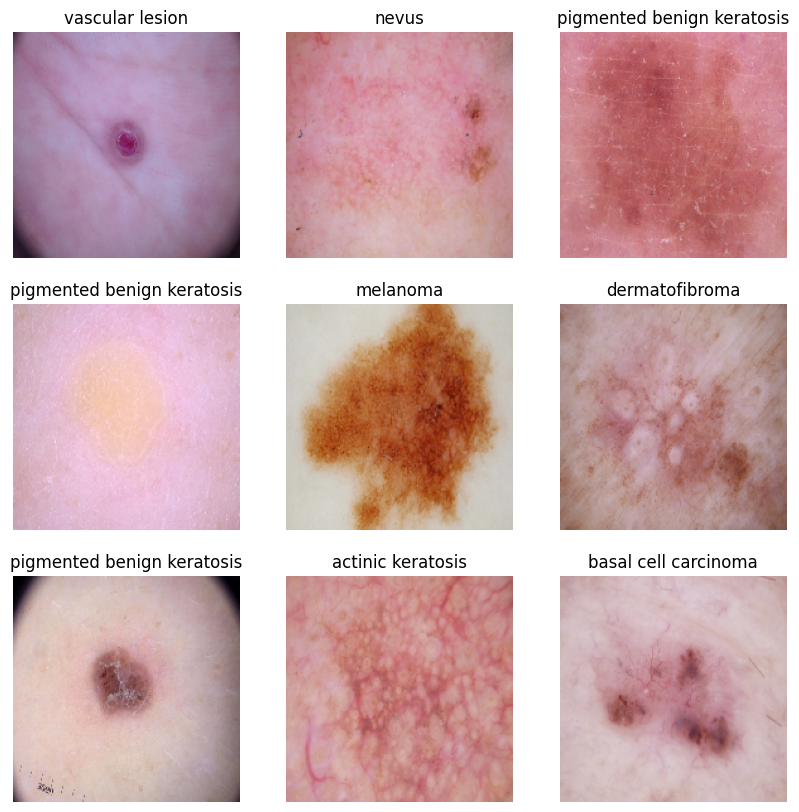

In [38]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [39]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creation of  Model 1

In [40]:
# Model 1
input_shape = (img_height,img_width,3)

model = Sequential()    #Sequential allows you to create models layer-by-layer

#First Convulation Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())   #Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.

#Dense Layer
model.add(layers.Dense(512,activation='relu'))

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names)))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [41]:
# Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and
# second-order moments.
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
# The summary of all layers.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model 1

In [43]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 357s 2s/step - loss: 2.1510 - accuracy: 0.2355 - val_loss: 1.8912 - val_accuracy: 0.3154
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.7768 - accuracy: 0.3544 - val_loss: 1.8366 - val_accuracy: 0.3870
Epoch 3/20
56/56 [==============================] - 2s 41ms/step - loss: 1.6059 - accuracy: 0.4085 - val_loss: 1.4488 - val_accuracy: 0.5034
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 1.4438 - accuracy: 0.4827 - val_loss: 1.5195 - val_accuracy: 0.4720
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: 1.3889 - accuracy: 0.5084 - val_loss: 1.4112 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.3455 - accuracy: 0.5184 - val_loss: 1.3643 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.2383 - accuracy: 0.5552 - val_loss: 1.5040 - val_accuracy: 0.4743
Epoch 8/20
56

### Visualizing training results

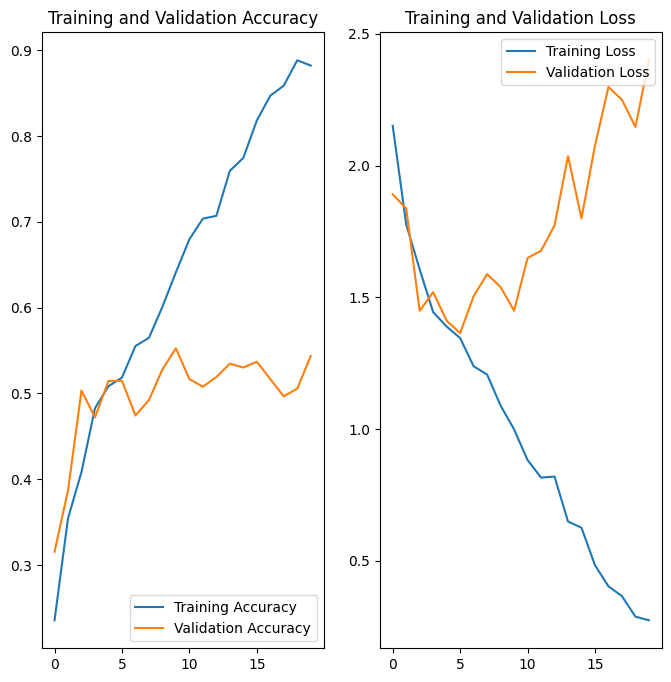

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations:
- From the above graphs it is clear that the model is overfitting.
- From the Training vs. Validation accuracy graphs we observe that as the epoch increases the difference between training accuracy and validation accuracy also increases.

### Create the model, compile and train the model


In [45]:
#Data augmentation strategy.

rescale = tf.keras.Sequential([
  #To rescale an input in the [0, 255] range to be in the [0, 1] range
  layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  #Randomly flip each image horizontally and vertically.
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),

  #Randomly rotate each image.
  layers.experimental.preprocessing.RandomRotation(0.2),

  #Randomly zoom each image during training.
  layers.experimental.preprocessing.RandomZoom(0.2),

  #Randomly translate each image during training.
  layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
])


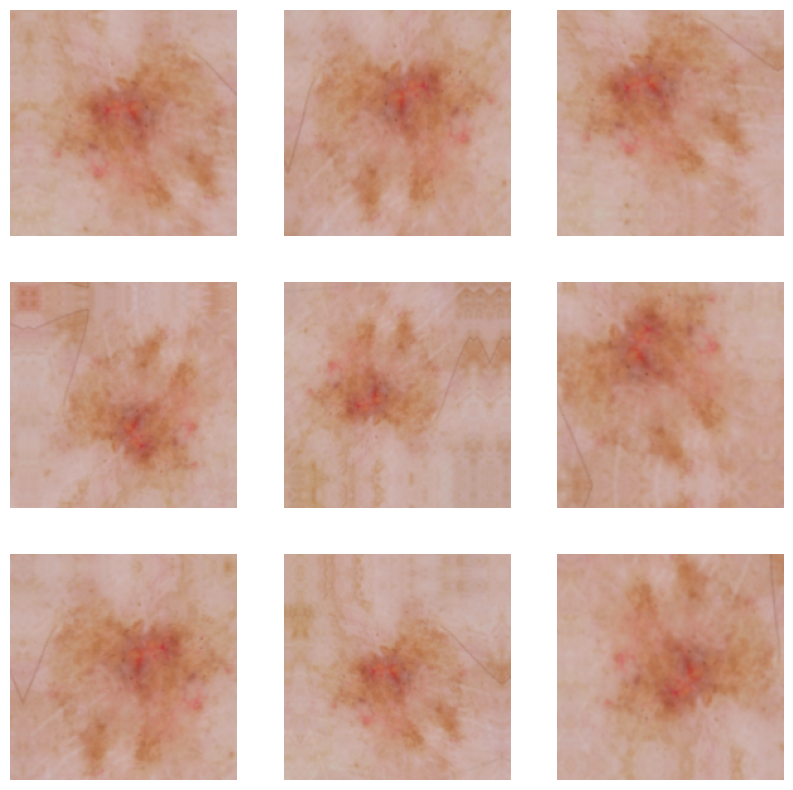

In [46]:
#Visualize the augmented image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Creating the model 2

In [47]:
# Model 2

#Dropout layer: randomly sets input units to 0 with a frequency of rate at each step during training time,
#which helps prevent overfitting.Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.


model2 = Sequential()                     #Sequential allows you to create models layer-by-layer

model2.add(data_augmentation)             #Augmentation layer
model2.add(rescale)                       #Rescaling layer

#First Convulation Layer
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Second Convulation Layer
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Third Convulation Layer
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model2.add(layers.Flatten())

#Dense Layer
model2.add(layers.Dense(512,activation='relu'))

#Dense Layer
model2.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model2.add(layers.Dropout(0.50))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model2.add(layers.Dense(len(class_names)))

### Compiling the model 2

In [48]:
model2.compile(optimizer='Adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model 2

In [49]:
## Your code goes here, note: train your model for 20 epochs
epochs =20
history = model2.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/20
56/56 [==============================] - 7s 66ms/step - loss: 2.4464 - accuracy: 0.1853 - val_loss: 2.0620 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 4s 66ms/step - loss: 2.0424 - accuracy: 0.1964 - val_loss: 1.9717 - val_accuracy: 0.2662
Epoch 3/20
56/56 [==============================] - 4s 63ms/step - loss: 1.9480 - accuracy: 0.2796 - val_loss: 1.8892 - val_accuracy: 0.3557
Epoch 4/20
56/56 [==============================] - 4s 63ms/step - loss: 1.7986 - accuracy: 0.3488 - val_loss: 1.6605 - val_accuracy: 0.4183
Epoch 5/20
56/56 [==============================] - 4s 65ms/step - loss: 1.6720 - accuracy: 0.4001 - val_loss: 1.6548 - val_accuracy: 0.3826
Epoch 6/20
56/56 [==============================] - 4s 63ms/step - loss: 1.5949 - accuracy: 0.4431 - val_loss: 1.5109 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 4s 63ms/step - loss: 1.5696 - accuracy: 0.4581 - val_loss: 1.5114 - val_accuracy: 0.4855
Epoch 8/20
56

### Visualizing the results

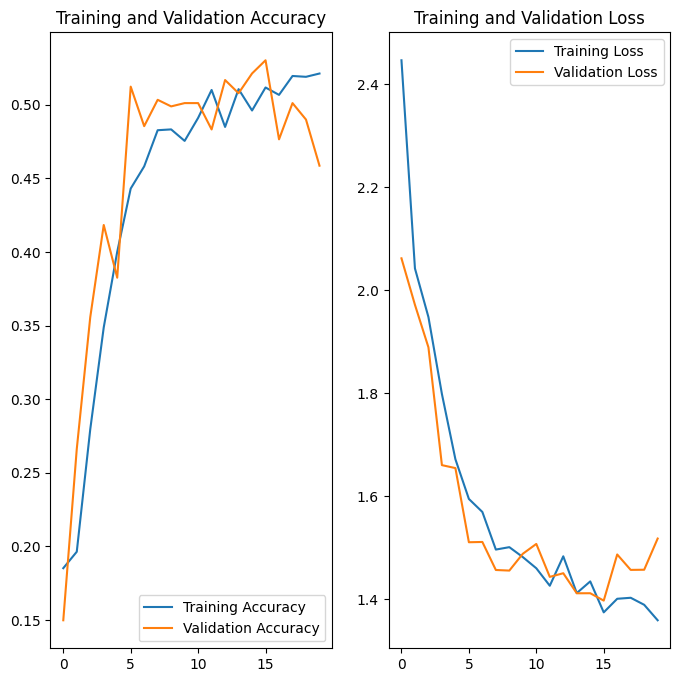

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### Observations:
- After the model fit weobserve that now there is no model overfit.
- This shows an improvement in the model and it is due to data augumentation and dropout layer.
- But the model perfomrance is still not upto the mark and there may be class imbalance.

### Class imbalance detection

In [51]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,vascular lesion,139
1,actinic keratosis,114
2,basal cell carcinoma,376
3,dermatofibroma,95
4,melanoma,438
5,nevus,357
6,pigmented benign keratosis,462
7,seborrheic keratosis,77
8,squamous cell carcinoma,181


<Axes: xlabel='No. of Image', ylabel='Class'>

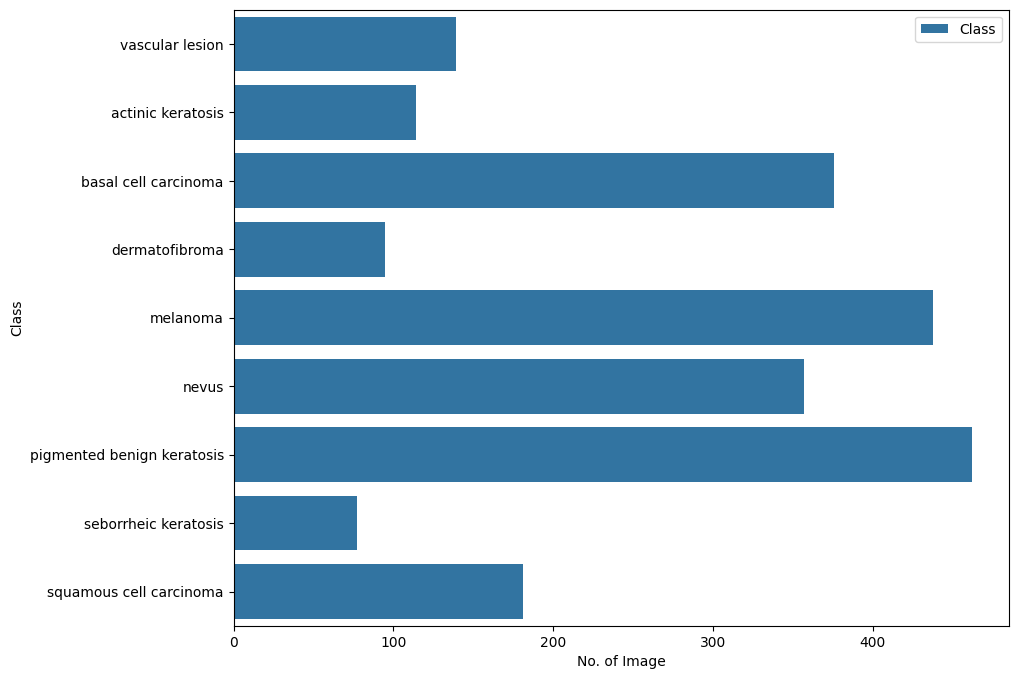

In [52]:
#Visualization of the Number of images in each class.

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

### Observations:
- The seborrheic keratosis class has least number of samples i.e., 77.
- The following classes dominate the data in terms of proportinate number of samples:
    - pigmented benign keratosis	(462)
    - melanoma	(438)
    - basal cell carcinoma	(376)
    - nevus	(357)


In [53]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [60]:
path_to_training_dataset="/content/drive/MyDrive/Upgrad/SkinCancer/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/SkinCancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BD54567F010>: 100%|██████████| 500/500 [00:17<00:00, 27.81 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/SkinCancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BD51C317730>: 100%|██████████| 500/500 [00:16<00:00, 29.83 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/SkinCancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BD51C3569B0>: 100%|██████████| 500/500 [00:19<00:00, 26.30 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/SkinCancer/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7BD51C139F00>: 100%|██████████| 500/500 [01:22<00:00,  6.03 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/SkinCancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7BD51C16E5F0>: 100%|██████████| 500/500 [01:19<00:00,  6.28 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/SkinCancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BD5B7FB3520>: 100%|██████████| 500/500 [00:17<00:00, 28.59 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/SkinCancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BD51C28BAF0>: 100%|██████████| 500/500 [00:36<00:00, 13.73 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/SkinCancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BD5505CD3C0>: 100%|██████████| 500/500 [00:17<00:00, 28.79 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/SkinCancer/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BD51C150F70>: 100%|██████████| 500/500 [00:18<00:00, 27.70 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [63]:
image_count_train = len(list(glob(data_dir_train + '/*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [64]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Upgrad/SkinCancer/Train/vascular lesion/output/vascular lesion_original_ISIC_0029448.jpg_ae56a10e-be7d-48e1-8828-e95158dbeb00.jpg',
 '/content/drive/MyDrive/Upgrad/SkinCancer/Train/vascular lesion/output/vascular lesion_original_ISIC_0025250.jpg_4f839eb9-8bda-4279-a014-396be372a99b.jpg',
 '/content/drive/MyDrive/Upgrad/SkinCancer/Train/vascular lesion/output/vascular lesion_original_ISIC_0026336.jpg_2aa95560-b5b5-4e31-ac84-8114ab4a952d.jpg',
 '/content/drive/MyDrive/Upgrad/SkinCancer/Train/vascular lesion/output/vascular lesion_original_ISIC_0031346.jpg_3ef752b8-23f1-4339-9488-0c44912d0e09.jpg',
 '/content/drive/MyDrive/Upgrad/SkinCancer/Train/vascular lesion/output/vascular lesion_original_ISIC_0033991.jpg_bbd98a93-38da-4031-a9c5-9bb2076a5c7c.jpg',
 '/content/drive/MyDrive/Upgrad/SkinCancer/Train/vascular lesion/output/vascular lesion_original_ISIC_0032775.jpg_f5610b05-53f3-44db-9793-e570ae114214.jpg',
 '/content/drive/MyDrive/Upgrad/SkinCancer/Train/vascular 

In [65]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [66]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [67]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [68]:
df2['Label'].value_counts()

vascular lesion               500
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

In [69]:
batch_size = 32
img_height = 180
img_width = 180

#### Creation of training dataset

In [71]:
data_dir_train="/content/drive/MyDrive/Upgrad/SkinCancer/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creation of  validation dataset

In [73]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Creation of Model 3

In [74]:
# Model 3

model3 = Sequential()

model3.add(rescale)   #Rescaling Layer

#First Convulation layer
model3.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Second Convulation Layer
model3.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Third Convulation Layer
model3.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(512,activation='relu'))

#Dropout layer
model3.add(layers.Dropout(0.25))

#Batch normalization: is a method used to make artificial neural networks faster and more stable through normalization
#of the layers' inputs by re-centering and re-scaling.
model3.add(layers.BatchNormalization())

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model3.add(layers.Dropout(0.50))

#Batch normalization
model3.add(layers.BatchNormalization())

#Dense layer with Softmax activation function.
model3.add(layers.Dense(len(class_names)))

### Compiling the Model 3

In [75]:

model3.compile(optimizer='Adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model 3

In [76]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model3.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/50
169/169 [==============================] - 47s 245ms/step - loss: 2.4752 - accuracy: 0.1693 - val_loss: 5.6478 - val_accuracy: 0.1359
Epoch 2/50
169/169 [==============================] - 43s 246ms/step - loss: 1.9773 - accuracy: 0.2706 - val_loss: 3.7934 - val_accuracy: 0.1470
Epoch 3/50
169/169 [==============================] - 41s 235ms/step - loss: 1.7255 - accuracy: 0.3474 - val_loss: 7.8544 - val_accuracy: 0.1403
Epoch 4/50
169/169 [==============================] - 41s 239ms/step - loss: 1.6465 - accuracy: 0.3756 - val_loss: 2.0203 - val_accuracy: 0.3326
Epoch 5/50
169/169 [==============================] - 42s 239ms/step - loss: 1.5068 - accuracy: 0.4256 - val_loss: 1.9193 - val_accuracy: 0.3571
Epoch 6/50
169/169 [==============================] - 41s 237ms/step - loss: 1.4721 - accuracy: 0.4284 - val_loss: 1.7569 - val_accuracy: 0.3370
Epoch 7/50
169/169 [==============================] - 40s 232ms/step - loss: 1.4124 - accuracy: 0.4598 - val_loss: 1.8133 - val_ac

### Visualization of the model 3 results

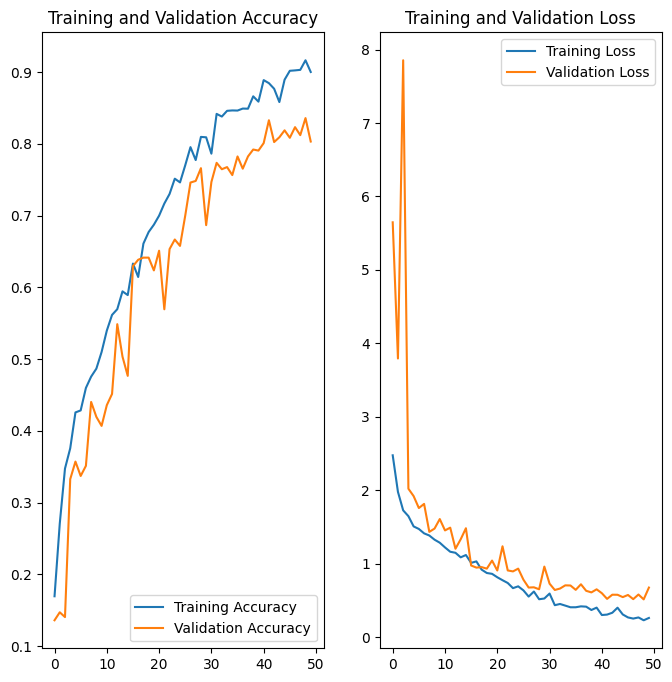

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations:
- From the above figures we can say that model overfit has reduced completely and that's a good improvement in the model.
- Class rebalancing helps in achieving the better training accuracy (89.91%) and validation accuracy (83.15%).